# Importing libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os 

import nonechucks as nc

import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np

import scipy

import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torchvision import datasets, transforms, models

nonechucks may not work properly with this version of PyTorch (1.3.1). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


# Visualizing some data 
The dataset is composed of three folders: **test**, **train** and **validation**. Each one has 12 different folders of a specific Chinese Zodiac animal. As you'll probably notice, this data has different aspect ratios.

TRAIN SET


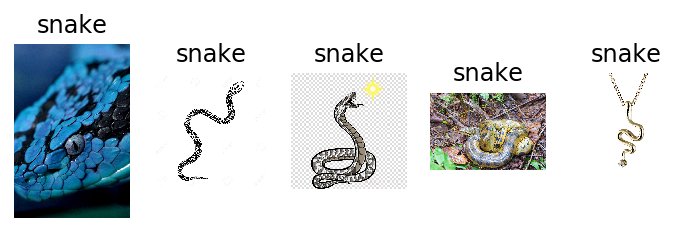

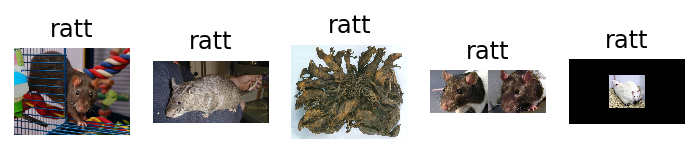

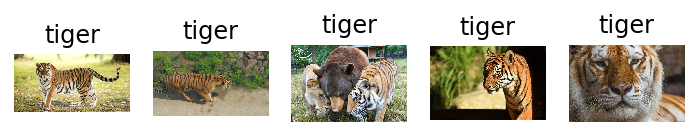

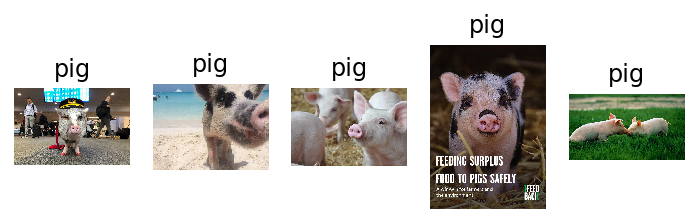

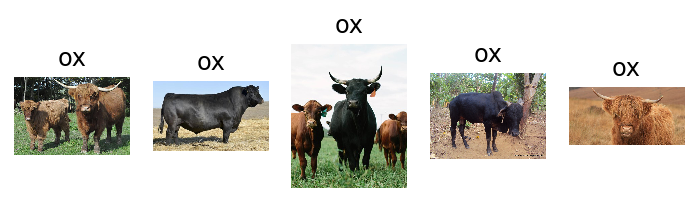

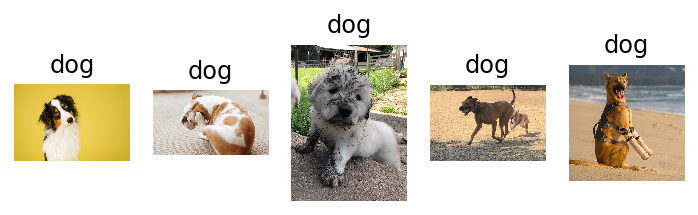

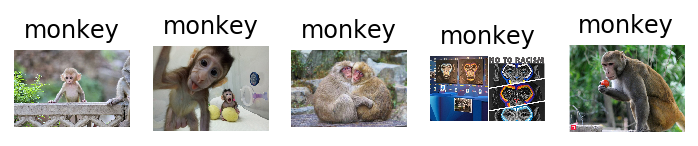

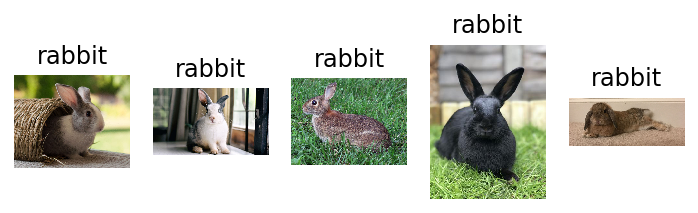

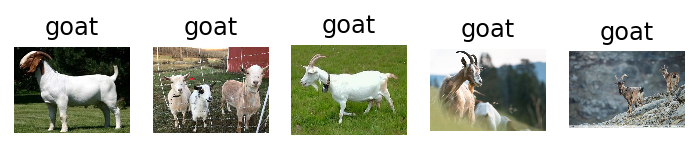

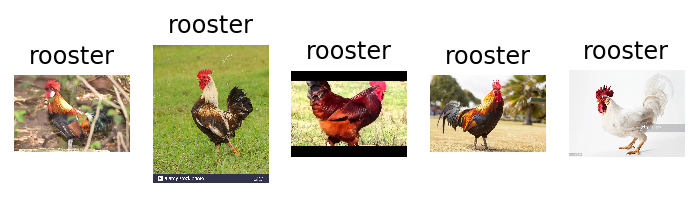

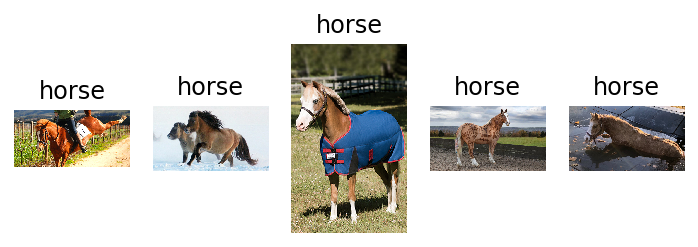

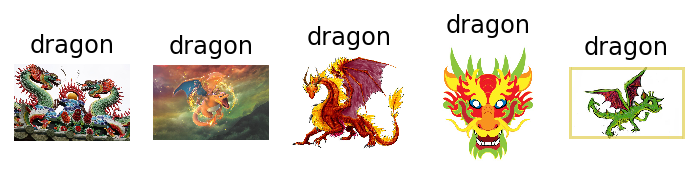

In [2]:
folders = ['train']   # you can add the other folders if you wish to see some images. They're pretty much the same

for f in folders:
    signsPath = 'signs/' + f
    signs = os.listdir(signsPath)
    print(f.upper() + ' SET')
    
    for s in signs:
        animalsPath = 'signs/' + f + '/' + s
        animals = os.listdir(animalsPath)
        
        fig = plt.figure()
        for i in range(5):
            
            sp = fig.add_subplot(1, 5, i+1)
            image = imread(animalsPath + '/' + animals[i])
            plt.imshow(image,cmap='Greys_r')
            plt.axis('off')
            sp.set_title(s)


# Loading data and pre-processing
For this step, we're doing some data pre-processing. Considering we're using a [VGG-NET CNN](https://pytorch.org/hub/pytorch_vision_vgg/), we're applying the transformations according to the documentation and normalization parameters so we can use the pre-trained model properly. All images will be resized to 330x330. Additionally, we're passing the data through *nonechucks*, a library to drop corrupt/invalid images from the data. The ```mean``` and the ```std``` are explained further on.

In [3]:
data_directory = './signs'

batch_size = 64
num_workers = 6

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transformations for each data set
train_transforms = transforms.Compose([transforms.Resize(330),
                                       transforms.RandomCrop(300),   
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(24),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean = mean, std = std)])

validation_transforms = transforms.Compose([transforms.Resize(330),
                                            transforms.CenterCrop(300),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean = mean, std = std)])

test_transforms = transforms.Compose([transforms.Resize(330),
                                      transforms.CenterCrop(300),                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = mean, std = std)])


# Setting up the data and data loaders and applying the previous transforms. Nonechucks is used to discard invalid data
training_data = datasets.ImageFolder(data_directory + '/train', transform = train_transforms)
test_data = datasets.ImageFolder(data_directory + '/test', transform = test_transforms)
validation_data = datasets.ImageFolder(data_directory + '/valid', transform = validation_transforms)

# Using nonechucks to drop invalid/corrupt images
training_data = nc.SafeDataset(training_data)
test_data = nc.SafeDataset(test_data)
validation_data = nc.SafeDataset(validation_data)

train_loader = torch.utils.data.DataLoader(training_data, batch_size = batch_size, shuffle=True, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size, num_workers = num_workers)

classes = ['dog','dragon','goat','horse', 'monkey', 'ox', 'pig', 'rabbit', 'ratt', 'rooster', 'snake', 'tiger']

In [4]:
# Helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

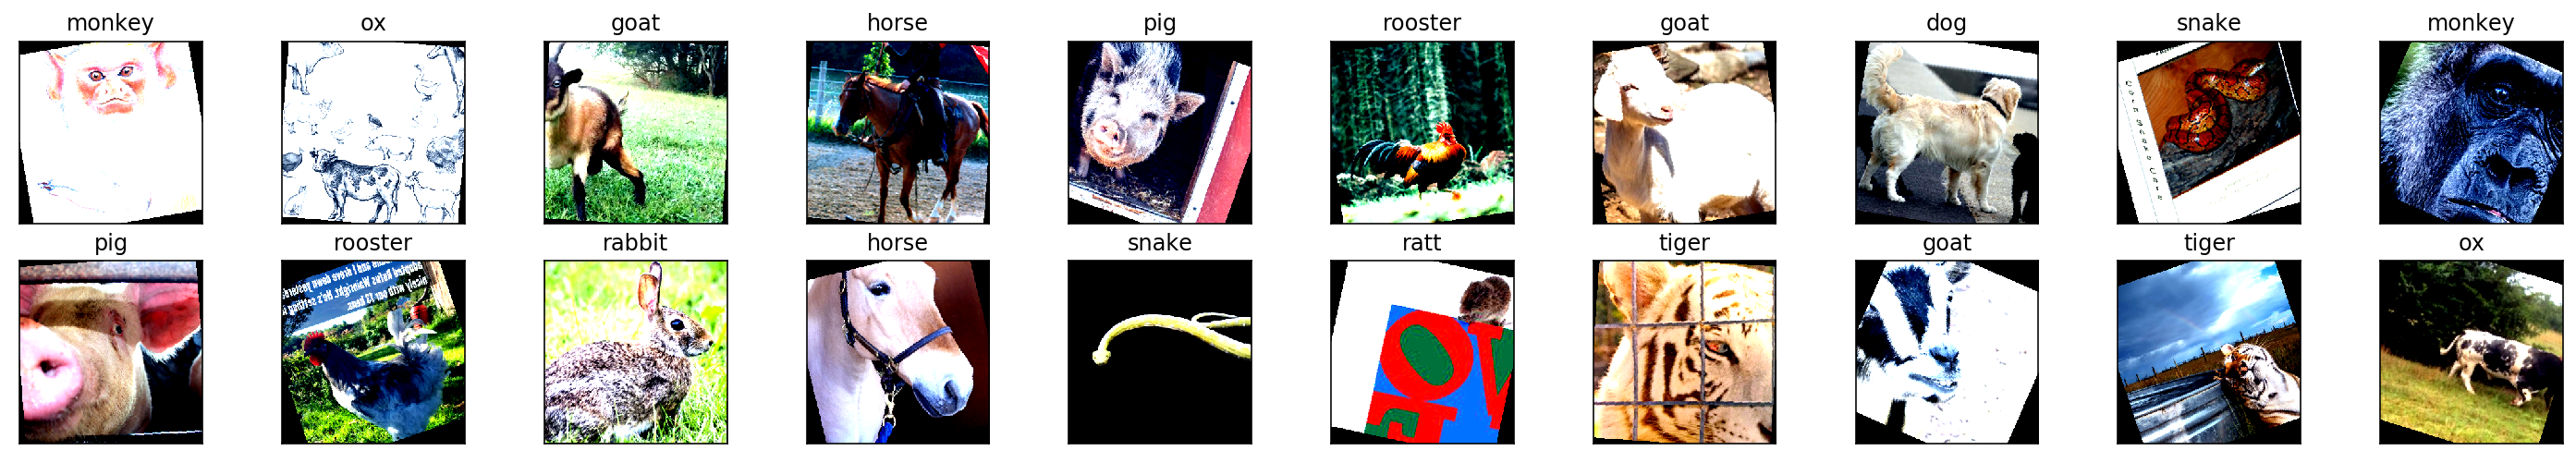

In [5]:
# Retrieve one batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])  

# Create model
For this example, we'll be using the Very Deep Convolutional Network architecture, already pre-trained. For this, we want to change the classifier with our own and we need to know the number of nodes so we can output 12 classes, as our problem suggests. According to [VGG19's](https://pytorch.org/hub/pytorch_vision_vgg/) documentation:


> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape ```(3 x H x W)```, where H and W are expected to be at least 224. The images have to be loaded in to a range of ```[0, 1]``` and then normalized using ```mean = [0.485, 0.456, 0.406]``` and std = ```[0.229, 0.224, 0.225]```.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model = models.vgg19_bn(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [17]:
# This model has two parts: the features and the classifier. The features are a stack of convolutional layers and the classifier is a single fully-connected layer.
# We want to replace the classifier, because this was originally trained on a different dataset, different from our problem.
# We don't want to replace the features, only the classifier. Nor do we want to change the model parameters; it's already trained, let's make use of that.
# We are freezing the model parameters so they don't update when we train it.

for param in model.parameters():
    param.requires_grad = False
    

# Define new classifier
classifier = nn.Sequential(nn.Linear(25088, 4096),
                                 nn.ReLU(),
                                 nn.Linear(4096, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(512, 12),
                                 nn.LogSoftmax(dim=1))

model.classifier = classifier

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Train the model
It's time to train our model! For each epoch, we're training and also validating the model to check if we're overfitting or not.

In [18]:
# Number of epochs to train the model
n_epochs = 20

# Track change in validation loss
valid_loss_min = np.Inf 

train_losses_array, validation_losses_array = [], []
for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    
    # TRAINING THE MODEL
    model.train()
    for data, target in train_loader:
        
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
        
    # VALIDATION
    model.eval()
    for data, target in validation_loader:

        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)

        valid_loss += loss.item()*data.size(0)
    
    # Calculating the average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
    
    # Adding losses to array to plot later
    train_losses_array.append(train_loss/len(train_loader))
    validation_losses_array.append(valid_loss/len(validation_loader))
        
    # Printing training/validation information per epoch 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # Saving model if validation loss has decreased from last iteration
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'vgg19_bn.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.958724 	Validation Loss: 0.369118
Validation loss decreased (inf --> 0.369118).  Saving model ...
Epoch: 2 	Training Loss: 0.462771 	Validation Loss: 0.309813
Validation loss decreased (0.369118 --> 0.309813).  Saving model ...
Epoch: 3 	Training Loss: 0.376836 	Validation Loss: 0.272015
Validation loss decreased (0.309813 --> 0.272015).  Saving model ...
Epoch: 4 	Training Loss: 0.350444 	Validation Loss: 0.278304
Epoch: 5 	Training Loss: 0.311933 	Validation Loss: 0.324148
Epoch: 6 	Training Loss: 0.308602 	Validation Loss: 0.252040
Validation loss decreased (0.272015 --> 0.252040).  Saving model ...
Epoch: 7 	Training Loss: 0.274936 	Validation Loss: 0.272063
Epoch: 8 	Training Loss: 0.258213 	Validation Loss: 0.272525
Epoch: 9 	Training Loss: 0.249292 	Validation Loss: 0.313316
Epoch: 10 	Training Loss: 0.236381 	Validation Loss: 0.283954
Epoch: 11 	Training Loss: 0.231227 	Validation Loss: 0.267481
Epoch: 12 	Training Loss: 0.221489 	Validation Loss: 0.4

In [19]:
model.load_state_dict(torch.load('vgg19_bn.pt'))

<All keys matched successfully>

# Testing the accuracy
Now we'll use the testing dataset to test the accuracy of our trained model.

In [20]:
# Track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    
    # Convert output probabilities to predicted class
    _, prediction = torch.max(output, 1)    
    
    # Compare predictions to true label
    correct_tensor = prediction.eq(target.data.view_as(prediction))
    
    # Convert the output into a numpy array
    if device == 'cuda': 
        correct = np.squeeze(correct_tensor.numpy())
    else:
        correct = np.squeeze(correct_tensor.cpu().numpy())
    
    # Calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.335440

Test Accuracy of   dog: 90% (50/55)
Test Accuracy of dragon: 89% (49/55)
Test Accuracy of  goat: 83% (46/55)
Test Accuracy of horse: 89% (49/55)
Test Accuracy of monkey: 89% (49/55)
Test Accuracy of    ox: 96% (53/55)
Test Accuracy of   pig: 92% (51/55)
Test Accuracy of rabbit: 89% (49/55)
Test Accuracy of  ratt: 85% (47/55)
Test Accuracy of rooster: 94% (52/55)
Test Accuracy of snake: 89% (49/55)
Test Accuracy of tiger: 87% (48/55)

Test Accuracy (Overall): 89% (592/660)


# Output visualization
Visualizing the training and validating loss and check if we're overfitting the model or not. We need to reach the sweet spot where both training loss and validation loss have met. If they've yet to do so, we can try to increase the learning rate. 

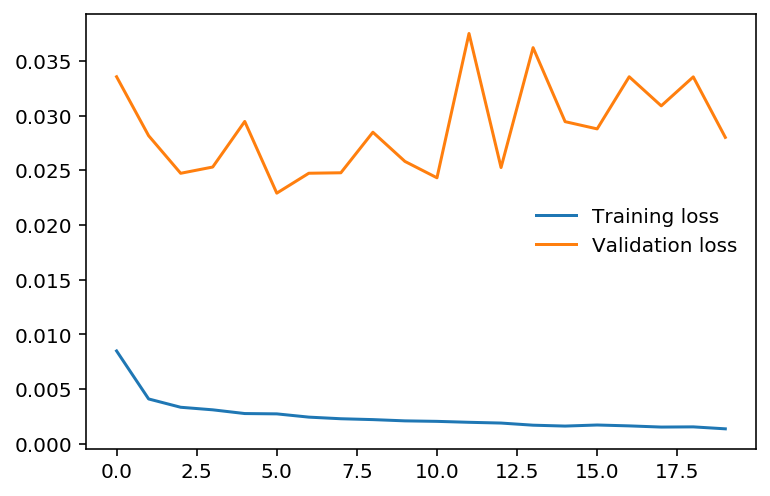

In [21]:
plt.plot(train_losses_array, label='Training loss')
plt.plot(validation_losses_array, label='Validation loss')
plt.legend(frameon=False)